In [1]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Modules used for preprocessing
from sklearn.preprocessing import StandardScaler

# Modules used for time series forecasting
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modules used for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
import evaluation

# Modules used for preprocessing
from datetime import datetime, timedelta
import preprocess

# Module for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

# Consolidating the data

In [20]:
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered=True, stationary=True)
temperature = preprocess.preprocess("temperature")
precipitation = preprocess.preprocess("precipitation")

In [21]:
electricity = electricity.drop(pd.to_datetime("2015-01-01"))

In [63]:
weather = pd.merge(temperature, precipitation, on='date', how='inner').set_index("date")

In [22]:
weather = temperature.set_index("date")

# Model template

In [243]:
from abc import ABC, abstractmethod

class Model(ABC):
   def __init__(self, data, cluster: str, window_stride = 28):
      self.data = data
      self.cluster = cluster
      self.trained_model = None
      self.ts_window_stride = window_stride
      self.ts_train = 180
      self.ts_test = 5
      self.MAX_IDX = len(electricity)
      self.forecasts = dict()

   def __standardize(self, train, test):
      scaler = StandardScaler()

      train_ = pd.DataFrame(scaler.fit_transform(train), 
                                  columns=train.columns,
                                  index = train.index)

      test_ = pd.DataFrame(scaler.transform(test), 
                                 columns=test.columns,
                                 index = test.index)
      return train_, test_
   
   @abstractmethod
   def train_model(self, train, train_idx):
      pass

   @abstractmethod
   def get_forecasts(self, test, test_idx):
      pass
   
   def cross_validate(self):
      train_idx = [0, self.ts_train]
      test_idx = [self.ts_train, self.ts_train + self.ts_test]

      for split_id in range(50):
         #print(split_id, train_idx, test_idx)
         train = self.data[train_idx[0]: train_idx[1]]
         test = self.data[test_idx[0]: test_idx[1]]
         train, test = self.__standardize(train, test)
         self.trained_model = self.train_model(train, train_idx)
         preds = self.get_forecasts(test, test_idx)
         self.forecasts[split_id] = {"pred": list(preds.values),
                                     "train_date_range": train_idx,
                                     "test_date_range": test_idx}

         train_idx = [train_idx[0] + self.ts_window_stride, 
                     min(train_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
         test_idx = [test_idx[0] + self.ts_window_stride, 
                     min(test_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
         
         if test_idx[0] > len(self.data):
            break
   
   def mape_boxplot_by_step(self):

      t = []

      with open("clusters.json", "r") as f:
            clusters = json.load(fp = f)
            cluster = clusters[self.cluster[-1]]

            l = preprocess.preprocess_modelling(as_numpy=False, 
                                                clustered=False, 
                                                stationary=True)
            
            mape = {"p1": [], "p2": [], 
                    "p3": [], "p4": [], "p5": []}
            for j in self.forecasts:
               train_start, train_end = self.forecasts[j]["train_date_range"]
               test_start, test_end = self.forecasts[j]["test_date_range"]
               train = l[cluster][train_start:train_end]
               test = l[cluster][test_start:test_end]
               train, test = self.__standardize(train, test)
               self.temp = test
               a, b, c, d, e = test.T.apply(lambda x: (x - self.forecasts[0]["pred"])*100 / x,
                                 axis = 1).replace([np.inf, -np.inf], 100).T.values.tolist()
               mape["p1"] = mape["p1"] + a
               mape["p2"] = mape["p2"] + b
               mape["p3"] = mape["p3"] + c
               mape["p4"] = mape["p4"] + d
               mape["p5"] = mape["p5"] + e
            
            sns.boxplot(pd.DataFrame.from_dict(mape, orient="columns"),
                        log_scale=True, orient='h', whis=60)

            plt.xlabel("log(Mean Absolute Percentage Error)")
            plt.ylabel("The ith forecast")
            plt.title(f"MAPE for each forecast across different train-test windows ({self.cluster})")
            plt.show()
   
   def mape_boxplot_by_client(self, num_clients: int):
      
      t = []

      with open("clusters.json", "r") as f:
            clusters = json.load(fp = f)
            cluster = clusters[self.cluster[-1]]

            l = preprocess.preprocess_modelling(as_numpy=False, 
                                                clustered=False, 
                                                stationary=True)
            
            for i in cluster:
               mape = []
               for j in self.forecasts:
                  train_start, train_end = self.forecasts[j]["train_date_range"]
                  test_start, test_end = self.forecasts[j]["test_date_range"]
                  train = l[[i]][train_start:train_end]
                  test = l[[i]][test_start:test_end]
                  train, test = self.__standardize(train, test)
                  m = mean_absolute_percentage_error(test, self.forecasts[j]["pred"])
                  mape.append(m)
               t.append(mape)
            
            mape_ = dict(zip(cluster[0:num_clients], t))
            sns.boxplot(pd.DataFrame.from_dict(mape_, orient="columns"),
                        log_scale=True, orient='h')

            plt.xlabel("log(Mean Absolute Percentage Error)")
            plt.ylabel("Clients in the cluster")
            plt.title(f"MAPE for each client across different train-test windows ({self.cluster})")
            plt.show()
               

# SARIMAX

In [244]:
class SARIMAX_model(Model):
    def __init__(self, data, exogs, cluster: str, window_stride = 28):
        super().__init__(data, cluster, window_stride)
        self.exogs = exogs
    
    def train_model(self, train, train_idx):
        model = SARIMAX(endog = train[self.cluster], 
                        exog = self.exogs[train_idx[0]: train_idx[1]], 
                        order = (1, 1, 1), 
                        seasonal_order = (1, 1, 1, 15))
        return model.fit()
    
    def get_forecasts(self, test, test_idx):
        return self.trained_model.predict(start = self.data.index[test_idx[0]], 
                                        end = self.data.index[test_idx[0]] + timedelta(len(test) - 1),
                                        exog = self.exogs[test_idx[0]: test_idx[1]])

In [245]:
m = SARIMAX_model(electricity, weather, "cluster_1")

In [246]:
m.cross_validate()

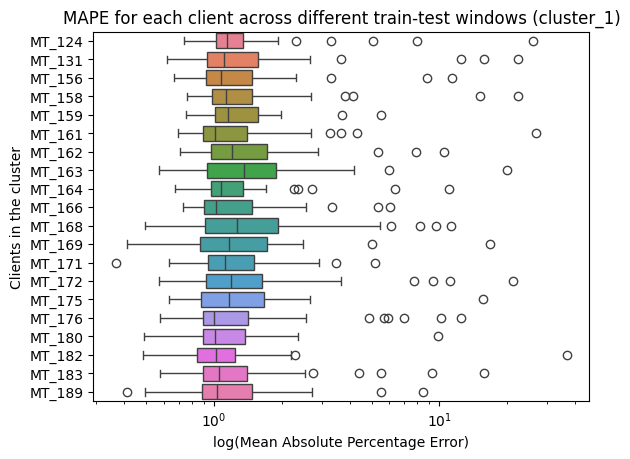

In [104]:
m.mape_boxplot_by_client(20)

In [ ]:
m.mape_boxplot_by_step()